In [ ]:
#|default_exp augment

# Augmentation

In [ ]:
#|export
import fastcore.all as fc
from functools import partial

from datasets import load_dataset

from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

from minai.conv import def_device
from minai.datasets import inplace
from minai.learner import MetricsCB, DeviceCB, ProgressCB, DataLoaders, Learner, TrainLearner, SingleBatchCB, MomentumLearner, lr_find
from minai.activations import Hooks
from minai.init import conv, GeneralRelu, init_weights, ActivationStats, set_seed
from minai.sgd import BatchSchedCB
from minai.resnet import ResBlock

In [ ]:
x1, y1 = 'image', 'label'
bs = 1024
ds = load_dataset('anubhavmaity/notMNIST')

In [ ]:
@inplace
def transformi(b): b[x1] = [TF.to_tensor(o) for o in b[x1]]
dsd = ds.with_transform(transformi)

In [ ]:
dls = DataLoaders.from_dd(dsd, batch_size=bs)

In [ ]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [ ]:
set_seed(42)
lr, epochs = 6e-2, 5

## Going wider

In [ ]:
def get_model(act=nn.ReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

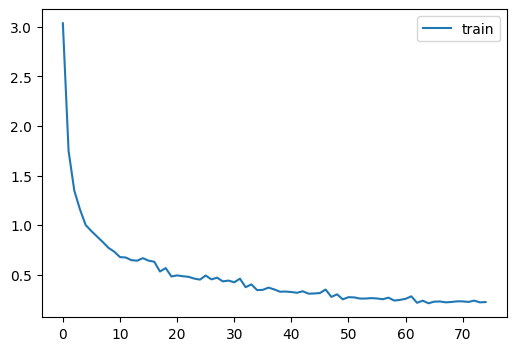

In [ ]:
learn.fit(epochs)

## Pooling

In [ ]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2, -1))

In [ ]:
def get_model2(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
#|export
def _flops(x, h, w):
    if x.dim() < 3: return x.numel()
    if x.dim() == 4: return x.numel()*h*w
    raise Exception()

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFlops|\n|--|--|--|--|--|\n'
    totp, totf = 0, 0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparams = sum(o.numel() for o in mod.parameters())
        totp += nparams
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MLFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4903556; MLFLOPS: 33.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3671552|14.7|
GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
Linear|(1024, 512)|(1024, 10)|5120|0.0|
BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


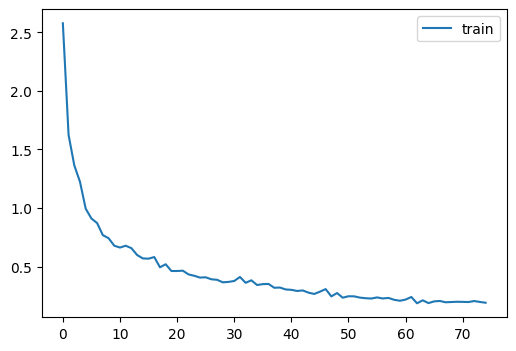

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)